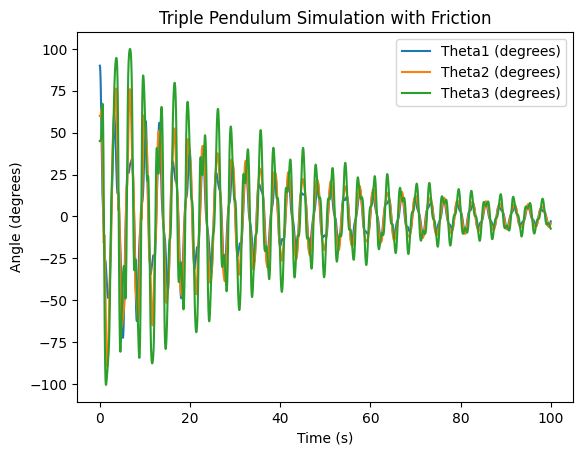

In [1]:
from __future__ import division, print_function
from math import sin, cos, pi, radians, degrees
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
l1 = 1.0  # Length of the first pendulum (m)
l2 = 1.0  # Length of the second pendulum (m)
l3 = 1.0  # Length of the third pendulum (m)
m1 = 1.0  # Mass of the first pendulum (kg)
m2 = 1.0  # Mass of the second pendulum (kg)
m3 = 1.0  # Mass of the third pendulum (kg)

# Friction/damping coefficients
damping1 = 0.05  # Damping for the first pendulum
damping2 = 0.05  # Damping for the second pendulum
damping3 = 0.05  # Damping for the third pendulum

def f(q, t):
    '''Triple Pendulum equation of motion with friction'''
    theta1, omega1, theta2, omega2, theta3, omega3 = q

    # Useful constants
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012 / 4

    # Useful sines and cosines
    sin0 = sin(theta1)
    sin1 = sin(theta2)
    sin2 = sin(theta3)
    cos01 = cos(theta1 - theta2)
    cos02 = cos(theta1 - theta3)
    cos12 = cos(theta2 - theta3)
    sin01 = sin(theta1 - theta2)
    sin02 = sin(theta1 - theta3)
    sin12 = sin(theta2 - theta3)

    # Recurrent patterns
    r1 = m12 * cos01 * cos02 - m012 * cos12
    r2 = m012 - m12 * cos01**2
    r3 = -m012 + m3 * cos02**2

    # Parts of the first equation
    od1_1 = 4 * m3 * m12
    od1_2 = r1 * cos01 + r2 * cos02
    od1_3 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od1_4 = (-g * (m2 + m3) * sin1
             + l1 * (m2 + m3) * sin01 * omega1**2
             - l3 * m3 * sin12 * omega3**2)
    od1_5 = -m3 * m12 * (cos02 - cos(theta1 - 2 * theta2 + theta3))**2 * m012
    od1_6 = (g * m012 * sin0
             + l2 * m12 * sin01 * omega2**2
             + l3 * m3 * sin02 * omega3**2)
    od1_7 = m3 * r1**2 + m12 * r3 * r2

    # Parts of the second equation
    od2_1 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od2_2 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od2_3 = -g * (m2 + m3) * sin1 + l1 * (m2 + m3) * sin01 * omega1**2 - l3 * m3 * sin12 * omega3**2

    # Parts of the third equation
    od3_1 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od3_2 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od3_3 = g * (m2 + m3) * sin1 - l1 * (m2 + m3) * sin01 * omega1**2 + l3 * m3 * sin12 * omega3**2

    # ThetaDot equations
    td1 = omega1
    td2 = omega2
    td3 = omega3

    # OmegaDot equations
    od1 = (mf * (od1_1 * od1_2 * od1_3 * r2
           - 4 * (-m3 * od1_2 * r1
                  + (m3 * r1**2 + m12 * r3 * r2) * cos01) * od1_4
           - (od1_5 + 4 * m3 * r1**2 + 4 * m12 * r3 * r2) * od1_6)
           / (l1 * od1_7 * m012 * r2)) - damping1 * omega1

    od2 = ((-m3 * r1 * m012 * od2_1 * r2
           - (m3 * (r1 * cos01 + r2 * cos02) * r1
              - (m3 * r1**2 + m12 * r3 * r2) * cos01) * od2_2
           + m012 * r3 * r2 * od2_3)
           / (l2 * od1_7 * r2)) - damping2 * omega2

    od3 = (-(m12 * od1_2 * od3_1
           + m12 * m012 * od3_2 * r2
           - r1 * m012 * od3_3)
           / (l3 * (m3 * r1**2 + m12 * r3 * r2))) - damping3 * omega3

    return array([td1, od1, td2, od2, td3, od3], float)

# Simulation parameters
a = 0.0  # Start time
b = 100.0  # End time
N = 10000  # Number of time steps
h = (b - a) / N  # Time step size

# Time points
tpoints = arange(a, b, h)

# Pre-allocate arrays for theta1, theta2, theta3
theta1_points = zeros_like(tpoints)
theta2_points = zeros_like(tpoints)
theta3_points = zeros_like(tpoints)

# Initial conditions in radians
initial_conditions = [pi / 2, 0, pi / 3, 0, pi / 4, 0]

# Convert initial conditions to radians
q = array(initial_conditions, float)

# Runge-Kutta 4th order method loop
for i, t in enumerate(tpoints):
    theta1_points[i] = degrees(q[0])  # Convert radians to degrees for plotting
    theta2_points[i] = degrees(q[2])  # Convert radians to degrees for plotting
    theta3_points[i] = degrees(q[4])  # Convert radians to degrees for plotting

    # RK4 coefficients
    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)

    # Update the state vector
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plotting
plt.plot(tpoints, theta1_points, label='Theta1 (degrees)')
plt.plot(tpoints, theta2_points, label='Theta2 (degrees)')
plt.plot(tpoints, theta3_points, label='Theta3 (degrees)')
plt.title("Triple Pendulum Simulation with Friction")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()

In [3]:
data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)
data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# create the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
#LSTM class definition
class LSTM(nn.Module):
  def __init__(self, in_size, hidden_size, out_size, num_layers):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(in_size, hidden_size, num_layers, batch_first=True)
    self.output = nn.Linear(hidden_size, out_size)

  def forward(self, X):
    hidden_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
    cell_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
    lstm_out, _ = self.lstm(X, (hidden_states, cell_states))
    out = self.output(lstm_out[:, -1, :])
    return out

train_losses = []
val_losses = []
def train(model, num_epochs, train_loader, test_loader, loss_func, optimizer):
  val_best = float('inf')
  epoch_same = 0
  best_model = None
  for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for sequences, targets in train_loader:
      optimizer.zero_grad()

      y_pred = model(sequences)
      loss = loss_func(y_pred, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
      for sequences, targets in test_loader:
        y_pred = model(sequences)
        loss = loss_func(y_pred, targets)
        val_loss += loss.item()
      val_loss /= len(test_loader)
      val_losses.append(val_loss)

    print(f"Epoch {epoch+1}; Training Loss {train_loss:.4f}; Validation Loss {val_loss:.4f}")

    if val_loss < val_best:
      val_best = val_loss
      epoch_same = 0
      best_model = model.state_dict()
    else:
      epoch_same += 1
    if epoch_same == 15:
      break

  if best_model:
    model.load_state_dict(best_model)

def evaluate(model, test_loader, loss_func):
  model.eval()
  eval_loss = 0
  inferences = []
  _targets = []

  with torch.no_grad():
    for sequences, targets in test_loader:
      y_pred = model(sequences)
      loss = torch.sqrt(loss_func(y_pred, targets))
      eval_loss += loss.item()
      inferences.append(y_pred.detach().cpu().numpy())
      _targets.append(targets.detach().cpu().numpy())
  loss_avg = eval_loss / len(test_loader)
  inferences = np.concatenate(inferences, axis=0)
  _targets = np.concatenate(_targets, axis=0)
  assert inferences.shape == _targets.shape, f"Shape mismatch: {inferences.shape} vs {targets.shape}"

  rmse = np.sqrt(mean_squared_error(_targets, inferences))
  print(f'RMSE: {rmse}')
  r2 = r2_score(_targets, inferences)
  print(f'R^2: {r2}')

Epoch 1; Training Loss 0.0137; Validation Loss 0.0017
Epoch 2; Training Loss 0.0011; Validation Loss 0.0005
Epoch 3; Training Loss 0.0003; Validation Loss 0.0003
Epoch 4; Training Loss 0.0002; Validation Loss 0.0002
Epoch 5; Training Loss 0.0001; Validation Loss 0.0001
Epoch 6; Training Loss 0.0001; Validation Loss 0.0001
Epoch 7; Training Loss 0.0001; Validation Loss 0.0001
Epoch 8; Training Loss 0.0001; Validation Loss 0.0001
Epoch 9; Training Loss 0.0001; Validation Loss 0.0001
Epoch 10; Training Loss 0.0001; Validation Loss 0.0001
Epoch 11; Training Loss 0.0000; Validation Loss 0.0001
Epoch 12; Training Loss 0.0000; Validation Loss 0.0000
Epoch 13; Training Loss 0.0000; Validation Loss 0.0001
Epoch 14; Training Loss 0.0000; Validation Loss 0.0000
Epoch 15; Training Loss 0.0000; Validation Loss 0.0000
Epoch 16; Training Loss 0.0000; Validation Loss 0.0000
Epoch 17; Training Loss 0.0000; Validation Loss 0.0000
Epoch 18; Training Loss 0.0000; Validation Loss 0.0000
Epoch 19; Training 

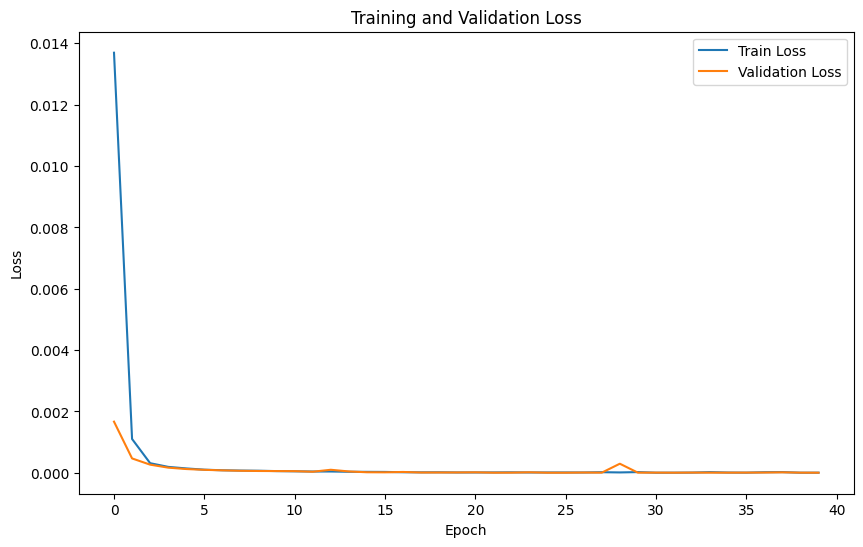

RMSE: 0.0016041425988078117
R^2: 0.9998732389180097


In [5]:
#hyperparameters
in_len = 3
hidden_size = 128
num_cells = 2
out_features = 3

model = LSTM(in_len, hidden_size, out_features, num_cells)


# Loss and Optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

train(model, num_epochs, train_loader, test_loader, loss_func, optimizer)

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


evaluate(model, test_loader, loss_func)

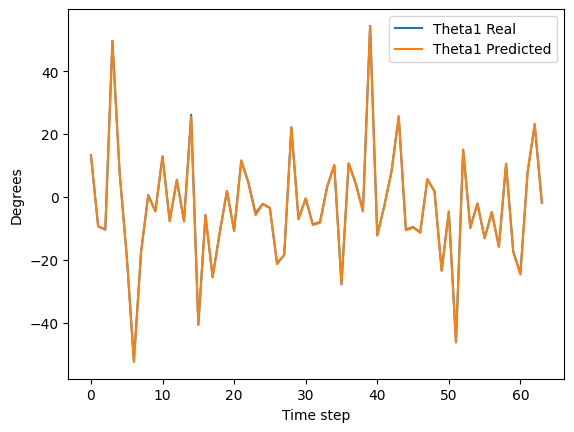

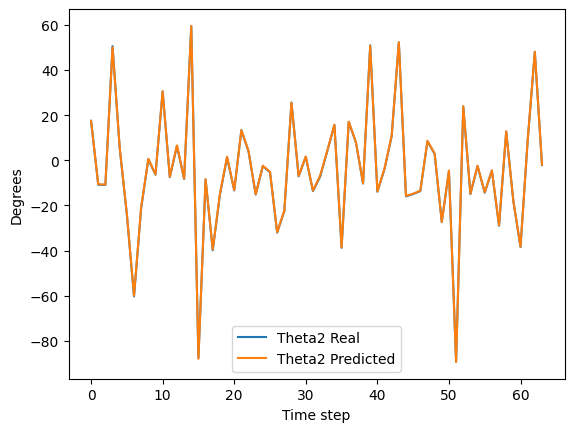

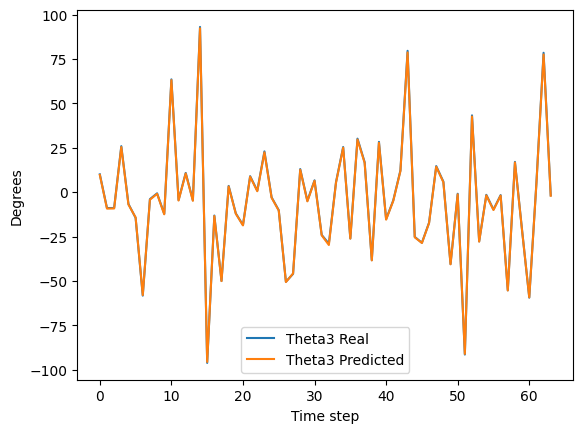

In [8]:
model.eval()
with torch.no_grad():
  for sequences, targets in test_loader:
    y_pred = model(sequences)
    break
  np_pred = y_pred.cpu().numpy()
  np_targets = targets.cpu().numpy()

  y_pred_ori = scaler.inverse_transform(np_pred)
  targets_ori = scaler.inverse_transform(np_targets)

  time_steps_to_plot = min(100, len(targets_ori))

plt.plot(targets_ori[:time_steps_to_plot, 0], label='Theta1 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 0], label='Theta1 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.plot(targets_ori[:time_steps_to_plot, 1], label='Theta2 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 1], label='Theta2 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.plot(targets_ori[:time_steps_to_plot, 2], label='Theta3 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 2], label='Theta3 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()